In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

from merfish_datasets import merfish_datasets
from merfish_datasets import merfish_datasets_params
directories = merfish_datasets
print(merfish_datasets)

{'P14NRa_ant': 'merfish_06142023/ant/region0', 'P28NRa_ant': 'merfish_06142023/ant/region1', 'P14NRa_pos': 'merfish_06142023/pos/region0', 'P28NRa_pos': 'merfish_06142023/pos/region1', 'P21NRa_ant': 'merfish_20231114/region0', 'P21DRa_ant': 'merfish_20231114/region2', 'P28DRa_ant': 'merfish_20231114/region1', 'P21NRa_pos': 'merfish_20231120/region0', 'P21DRa_pos': 'merfish_20231120/region1', 'P28DRa_pos': 'merfish_20231120/region2', 'P14NRb_ant': 'merfish_202404051211/region_0', 'P28NRb_ant': 'merfish_202404051211/region_1', 'P14NRb_pos': 'merfish_202404051214/region_0', 'P28NRb_pos': 'merfish_202404051214/region_1', 'P21NRb_ant': 'merfish_202404091526/region_2', 'P21DRb_ant': 'merfish_202404091526/region_1', 'P28DRb_ant': 'merfish_202404091526/region_0', 'P21NRb_pos': 'merfish_202404091601/region_0', 'P21DRb_pos': 'merfish_202404091601/region_2', 'P28DRb_pos': 'merfish_202404091601/region_1', 'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P1

In [3]:
# name = 'P28NRa_ant'
def run_one_sample(name):
    dirc = directories[name]

    full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
    f1   = full_dirc + 'detected_transcripts.csv'
    fout = full_dirc + 'detected_transcripts_v1l23_241010.csv'

    f_main_l0 = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_l0_hemibrain_240723.h5ad'
    f_main_l2 = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_l2_v1_240723.h5ad'

    adata_l0 = ad.read(f_main_l0, backed='r')
    adata_l2 = ad.read(f_main_l2, backed='r')

    bound_l, bound_r = adata_l2.uns['v1_window']
    bound_d = 400

    cond = np.all([
        adata_l2.obs['width'] > bound_l, 
        adata_l2.obs['width'] < bound_r, 
        adata_l2.obs['depth'] < bound_d, 
    ], axis=0)
    adatasub = adata_l2[cond]

    rotation_angle = adata_l2.uns['rotation']
    ref_line = np.array(adata_l2.uns['ref_line'])

    # get FOVs
    fovs = np.unique(adatasub.obs['fov'])

    # go over all tranascripts - select only those that are within these FOVs
    chunks = pd.read_csv(f1, chunksize=1000000)
    dfsubs = []

    ti = time.time()
    for i, chunk in enumerate(chunks):
        print('.', end='')
        dfsub = chunk[chunk['fov'].isin(fovs)]
        if len(dfsub) > 0:
            print(len(dfsub))
            dfsubs.append(dfsub)
    print('')
    df_v1l23 = pd.concat(dfsubs)

    # check results
    query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

    abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  
    fig, ax = plt.subplots()
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='global_x', y='global_y', hue='gene', hue_order=query_genes, 
                    s=4, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()
    plt.show()


    # (center_x, center_y) raw 
    # (x,y) rotation1 
    # (x2,y2) rotation2, subtract mean

    # get the original operations

    # (rotation 1 + rotation 2) -> -(xshift, yshift)

    rotations = merfish_datasets_params[name]
    alpha1, alpha2 = rotations['rotation'], rotations['rotation2']

    xr2, yr2 = utils_merfish.rot2d(adata_l0.obs['x'].values, 
                                   adata_l0.obs['y'].values,
                                   alpha2) #adata_l0.obs['x']
    ## check
    # plt.scatter(xr2-xshift, adata_l0.obs['x2'])
    xshift = np.mean(xr2)
    yshift = np.mean(yr2)

    # reference line
    ref_line_obj = utils_merfish.RefLineSegs(ref_line)

    x = df_v1l23['global_x'].values
    y = df_v1l23['global_y'].values

    xr, yr = utils_merfish.rot2d(x, y, alpha1+alpha2)
    xr = xr - xshift 
    yr = yr - yshift 
    XY = np.vstack([xr, yr]).T 

    df_v1l23['x'] = xr
    df_v1l23['y'] = yr
    depth, width = ref_line_obj.dists_to_qps(XY)
    df_v1l23['depth'] = depth 
    df_v1l23['width'] = width 

    cond_spots = np.all([
        df_v1l23['width'] > bound_l, 
        df_v1l23['width'] < bound_r, 
        df_v1l23['depth'] < bound_d, 
    ], axis=0)

    df_v1l23_new = df_v1l23[cond_spots]

    abc = df_v1l23_new[df_v1l23_new['gene'].isin(query_genes)]  

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='width', y='depth', hue='gene', hue_order=query_genes, 
                    s=4, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()
    plt.show()

    df_v1l23_new.to_csv(fout, header=True, index=False)
    !head $fout

In [4]:
names = [
    'P28NRa_ant',
    'P28NRa_pos',
    
    'P28NRb_ant',
    'P28NRb_pos',
    
    'P28DRa_ant',
    'P28DRa_pos',
    
    'P28DRb_ant',
    'P28DRb_pos',
]

**************************
P28NRa_ant
.....................................................................................210051
.224821
...118513
.980818
....356394
........


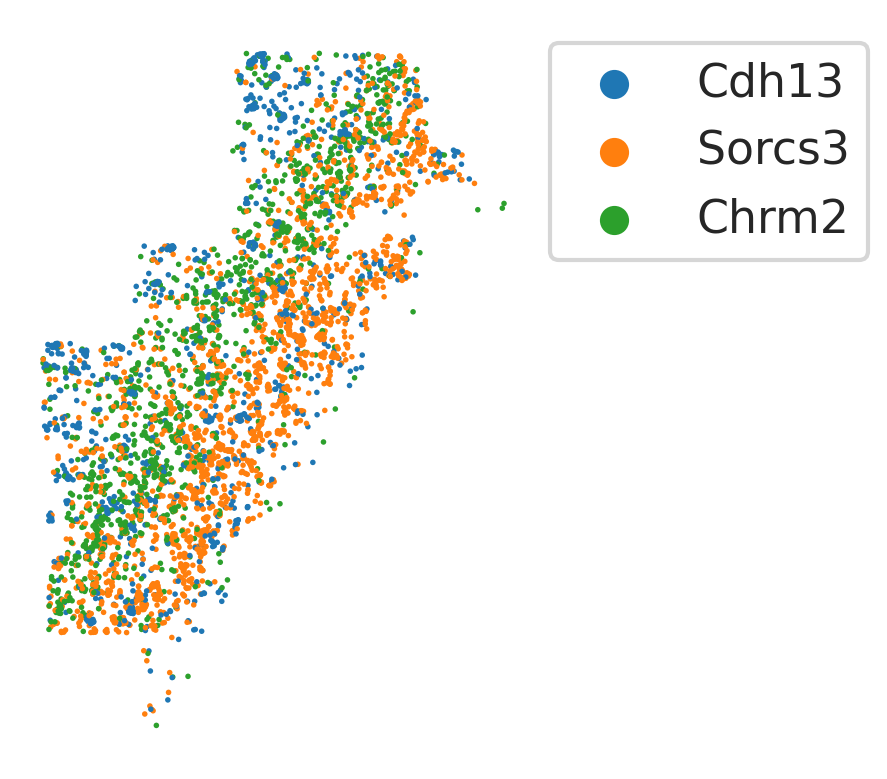

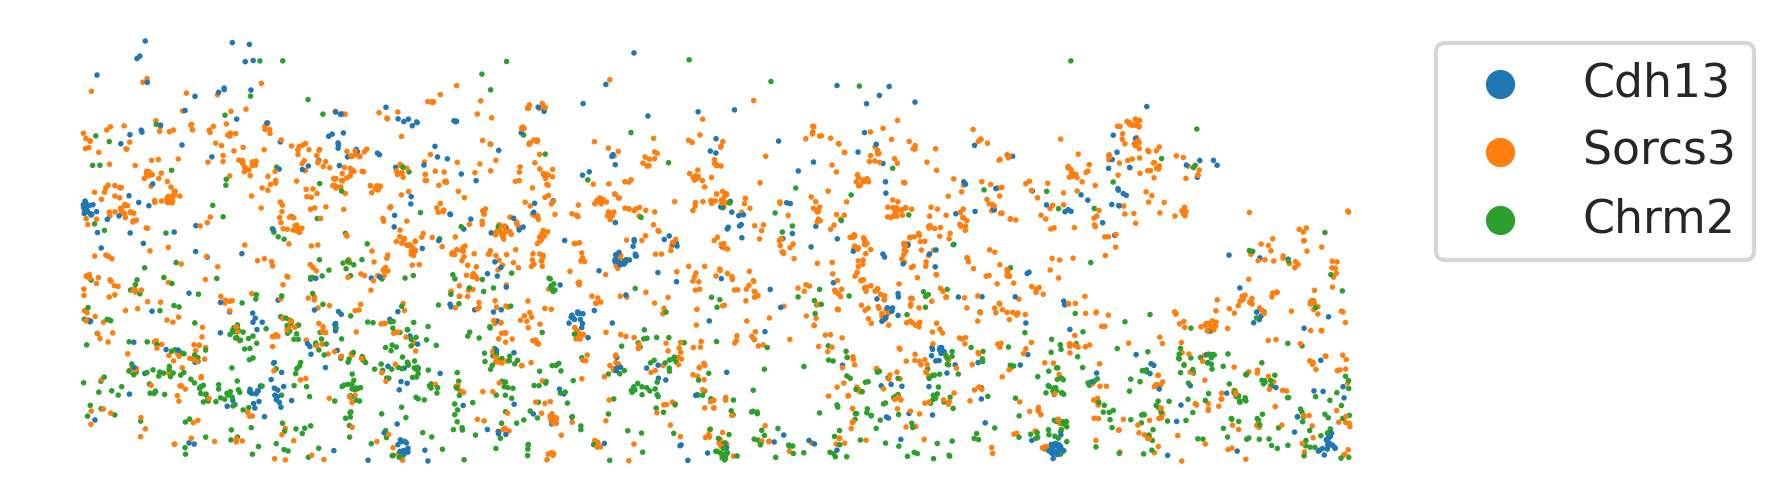

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
18,0,12088.416,7427.0527,0.0,1045.8152127602802,1970.3057414012255,2262,Cdh4,ENSMUST00000000314,2595481503174100051,365.63322229210394,6043.649292485479
19,0,12150.295,7427.939,0.0,1088.9435645331582,2014.687510654434,2262,Cdh4,ENSMUST00000000314,2595481503174100082,314.3981354391254,6078.358974763742
24,0,12223.335,7431.532,0.0,1138.0500091662188,2068.8752246171025,2262,Cdh4,ENSMUST00000000314,-1,252.52873241245535,6117.738336320568
39,0,12043.761,7450.264,0.0,997.8264918162399,1955.1427557174975,2262,Cdh4,ENSMUST00000000314,-1,388.76495812534114,5998.099537059139
45,0,12084.694,7463.9487,0.0,1017.0939495220464,1993.7633017603093,2262,Cdh4,ENSMUST00000000314,2595481503229100018,347.4017920517153,6010.423091556752
46,0,12183.847,7464.585,0.0,1086.755776152167,2064.3249924801676,2262,Cdh4,ENSMUST00000000314,-1,265.90660858116274,6067.531332223302
52,0,12153.186,7470.8125,0.0,1060.671667654367

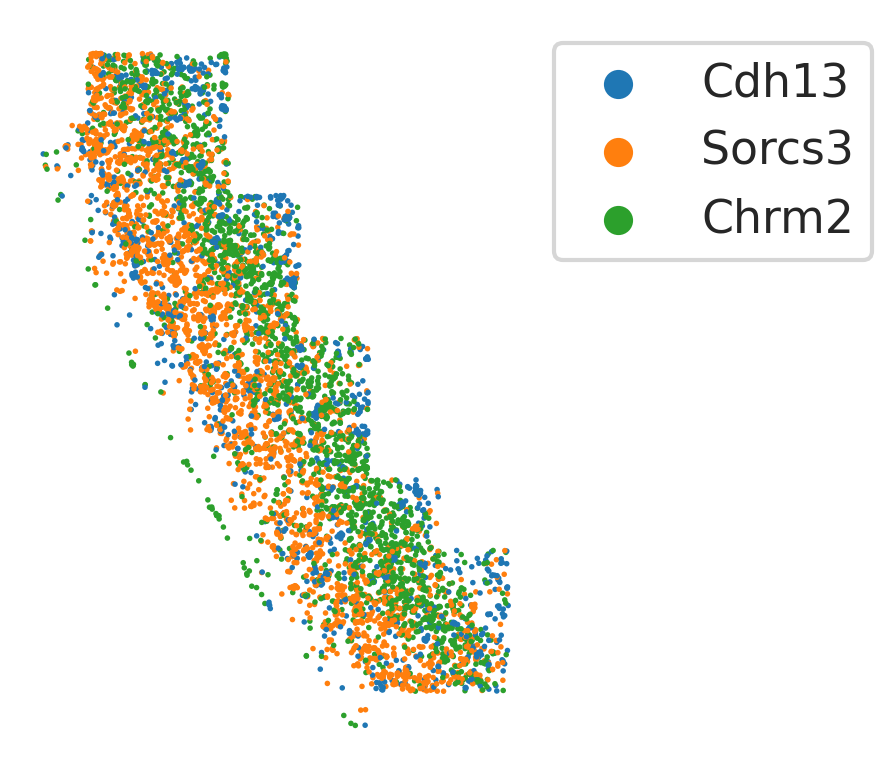

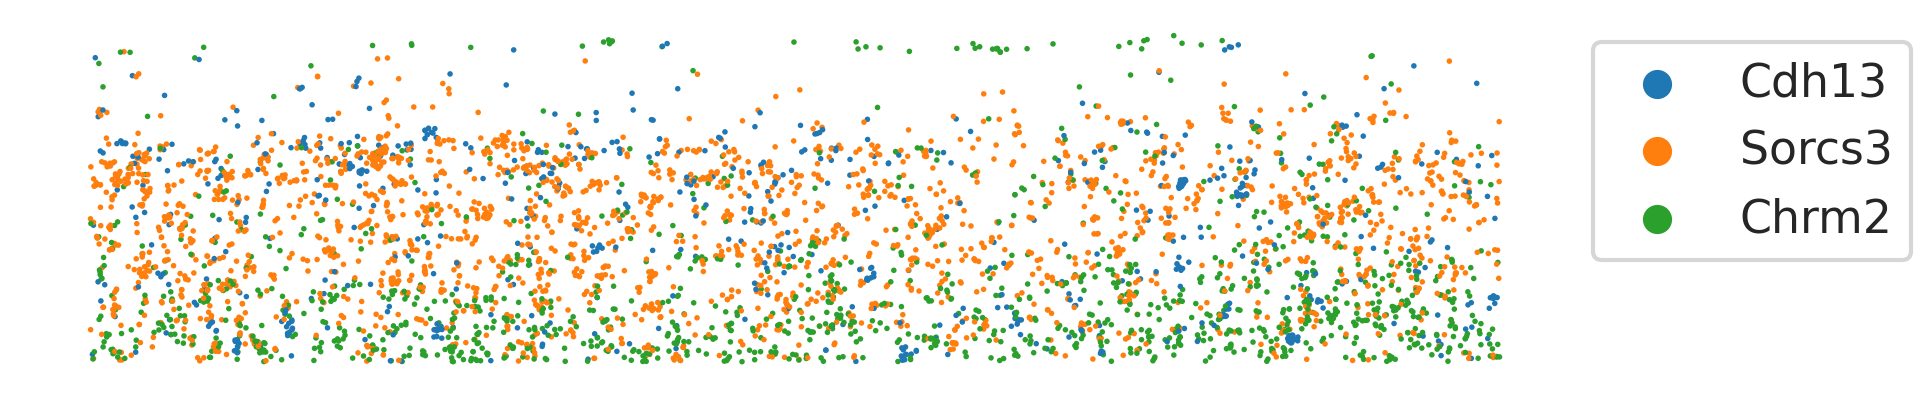

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
18,0,864.09937,7355.591,0.0,-1825.2075546897922,1254.118113064334,2155,Cdh4,ENSMUST00000000314,-1,487.2804173189119,1408.1813192035252
26,0,929.3242,7361.709,0.0,-1774.760555807754,1212.3232727568934,2155,Cdh4,ENSMUST00000000314,-1,545.0785711335311,1439.0209331464796
31,0,950.5252,7367.076,0.0,-1755.974142845189,1201.1269439835855,2155,Cdh4,ENSMUST00000000314,2596588902763100019,562.5604915465906,1452.1613117053903
41,0,950.6108,7371.1533,0.0,-1753.030528025788,1203.9495021220478,2155,Cdh4,ENSMUST00000000314,-1,561.0643736958983,1455.955166476838
56,0,979.4297,7380.3096,0.0,-1726.1780065888724,1190.0459443262894,2155,Cdh4,ENSMUST00000000314,-1,584.1090139038986,1475.5335061557746
58,0,865.7034,7381.6177,0.0,-1805.6696781376577,1271.3875486360153,2155,Cdh4,ENSMUST00000000314,2596588902762100042,478.70573945217564,1432.8072592792382
60,0,882.41003,7383.32,0.0,-1792.6525989002694,1260.77788514

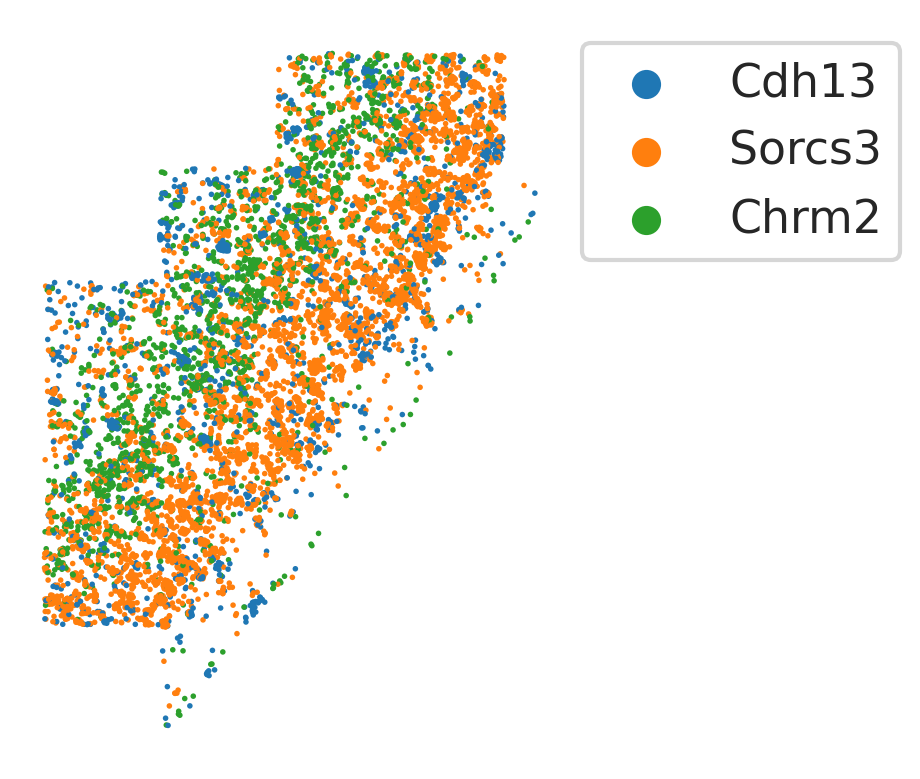

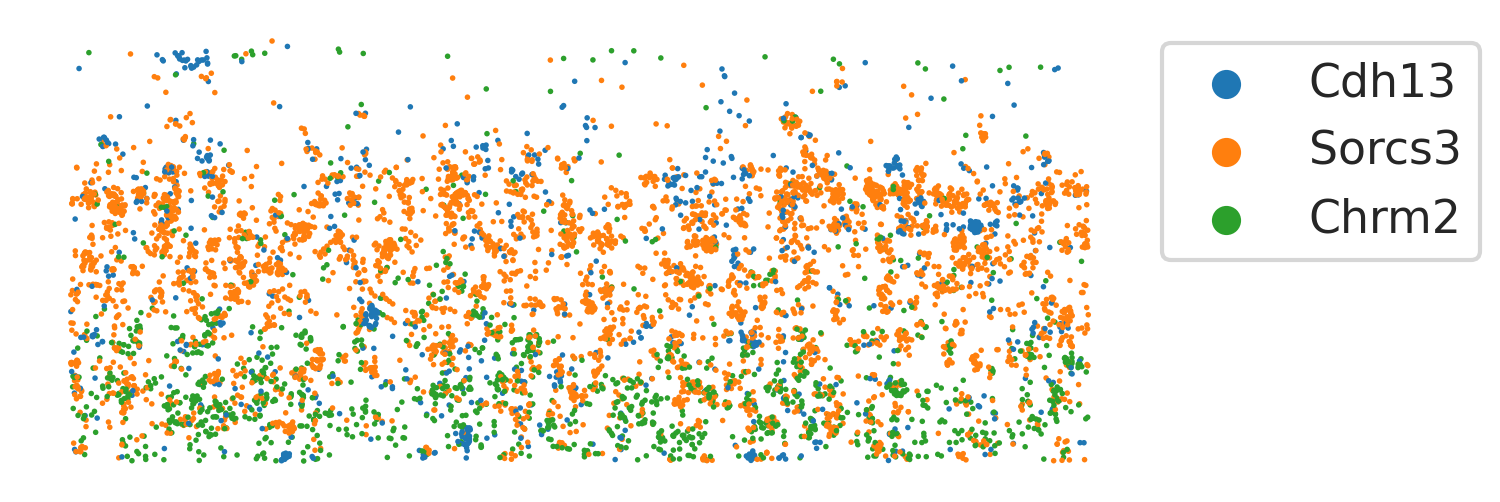

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
10,0,6734.1885,6801.9263,0.0,1954.823645159436,2095.180198478285,1307,Cdh4,ENSMUST00000000314,-1,28.999344818645014,6444.40377360966
11,0,6743.024,6802.656,0.0,1960.5553113063781,2101.9438162616916,1307,Cdh4,ENSMUST00000000314,1988491603010100012,20.969629134560428,6448.161723632316
33,0,6713.392,6836.9185,0.0,1915.3750770758538,2105.2180742119745,1307,Cdh4,ENSMUST00000000314,-1,29.6548816604302,6403.703420484177
11,1,6749.392,6801.532,0.0,1965.8529553110275,2105.651884222234,1307,Pdgfra,ENSMUST00000000476,1988491603010100014,16.002372243088345,6452.301911909934
22,1,6731.8096,6826.0137,0.0,1936.1091449565179,2110.5304260376724,1307,Pdgfra,ENSMUST00000000476,1988491603010100015,19.092462556865083,6422.319487616646
24,1,6727.006,6831.923,0.0,1928.5339807203452,2111.3122740056315,1307,Pdgfra,ENSMUST00000000476,1988491603010100015,20.323956714445973,6414.804314858164
25,1,6726.9717,6832.1665,0.

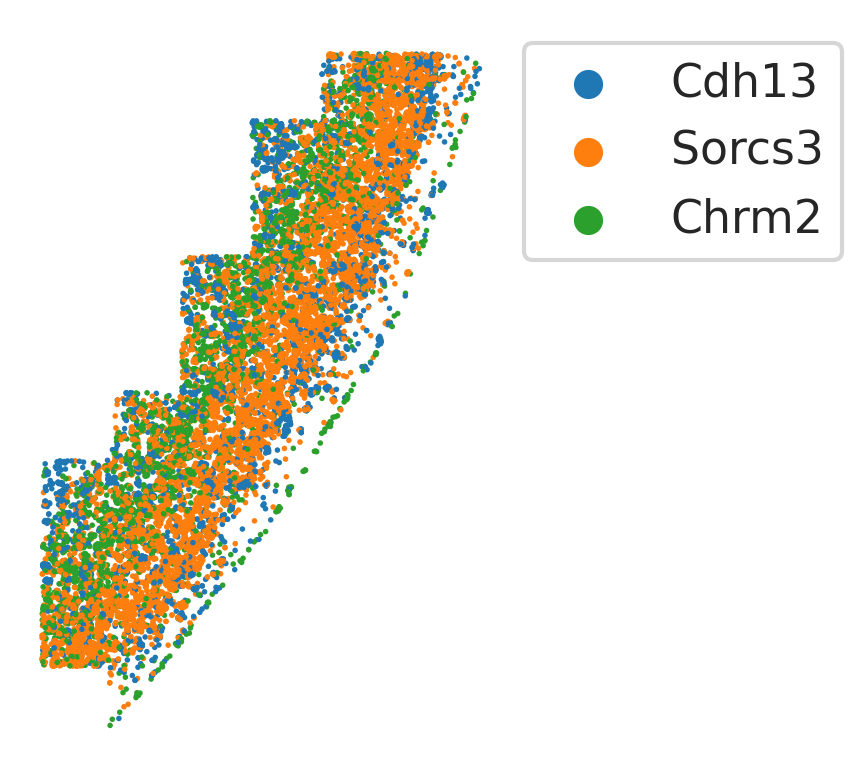

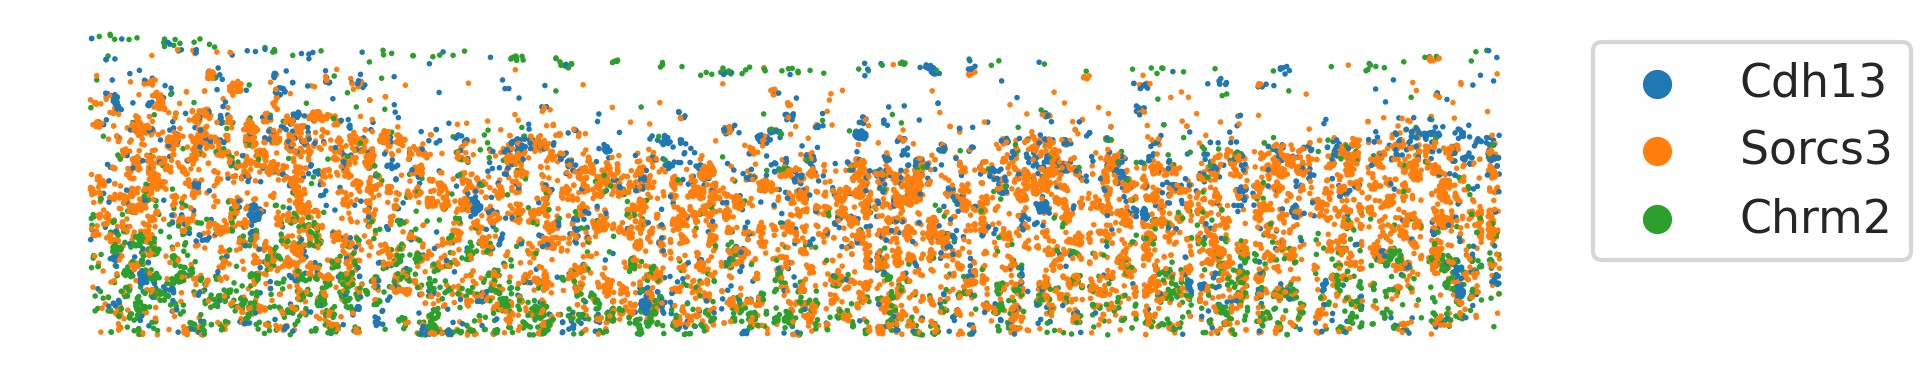

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
16,1,6925.0474,6439.727,0.0,2740.1551625435577,1790.154925638105,2012,Pdgfra,ENSMUST00000000476,-1,47.70822152742753,7768.580758674425
25,1,6984.0093,6456.6924,0.0,2769.851172479658,1843.8436343452895,2012,Pdgfra,ENSMUST00000000476,1988562202903100018,-14.398635719195882,7758.180608049807
66,1,6923.8774,6520.8384,0.0,2681.973426638035,1846.6820316756503,2012,Pdgfra,ENSMUST00000000476,-1,36.42127207731353,7686.431798406969
79,1,6958.3022,6539.2354,0.0,2693.306792705537,1884.0326846501312,2012,Pdgfra,ENSMUST00000000476,1988562202960100016,-1.774218008711518,7672.936717487203
82,1,6958.3633,6541.5786,0.0,2691.693104320191,1885.7327814841365,2012,Pdgfra,ENSMUST00000000476,1988562202960100016,-2.2345964735519637,7670.63837653793
85,1,6959.4453,6544.018,0.0,2690.733277575409,1888.2227873034071,2012,Pdgfra,ENSMUST00000000476,1988562202960100016,-3.7173059706235687,7668.419600094189
87,1,6959.4873,6

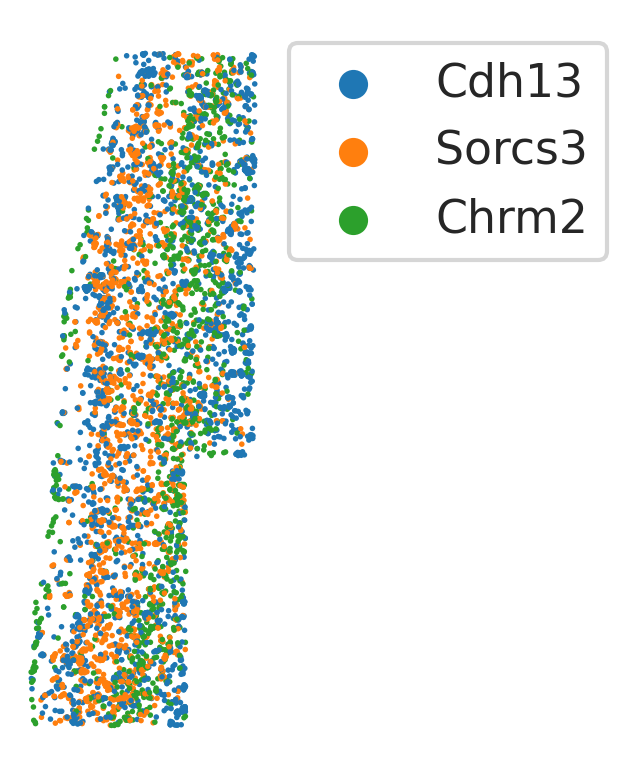

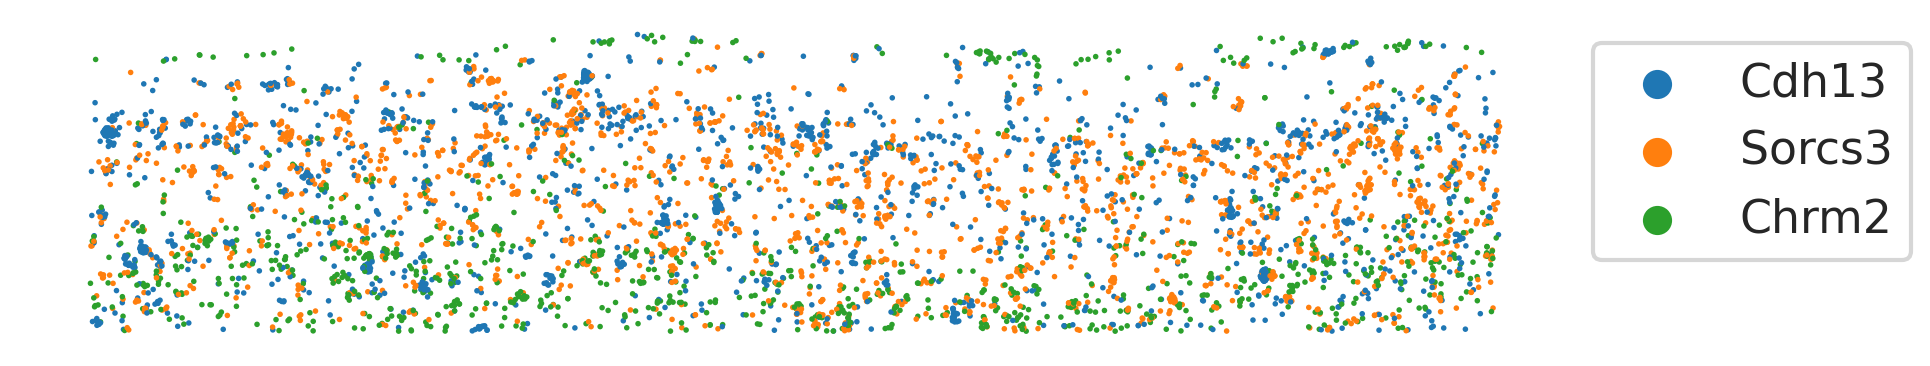

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
40,0,3712.0605,10419.0,0.0,2160.9136354403136,1064.8036232297054,1151,Cdh4,ENSMUST00000000314,-1,466.3922951619324,6683.0467590163125
91,0,3633.5032,10451.32,0.0,2239.315726149968,1097.4983316034613,1151,Cdh4,ENSMUST00000000314,-1,391.98776996005586,6725.381749210646
97,0,3626.0957,10453.725,0.0,2246.2542114403623,1101.0356332763477,1151,Cdh4,ENSMUST00000000314,-1,384.8765392617612,6728.557513560477
120,0,3648.5596,10466.765,0.0,2239.590507845138,1075.9305848277781,1151,Cdh4,ENSMUST00000000314,-1,408.5948086544421,6739.145813718021
137,0,3812.5273,10480.677,0.0,2133.485104819443,950.1506427223503,1151,Cdh4,ENSMUST00000000314,4207478901294100025,573.1138461798527,6735.619246122978
149,0,3623.5037,10492.9,0.0,2275.78794037018,1075.1675459002,1151,Cdh4,ENSMUST00000000314,4207478901292100023,386.4468310172325,6767.786753583738
175,0,3779.2515,10517.633,0.0,2183.146486854381,947.5483483462267,115

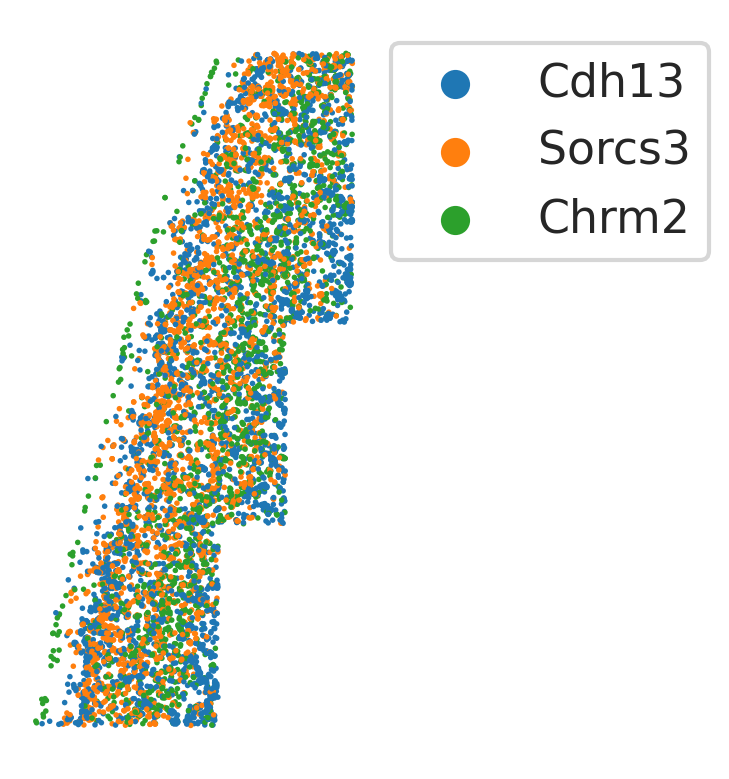

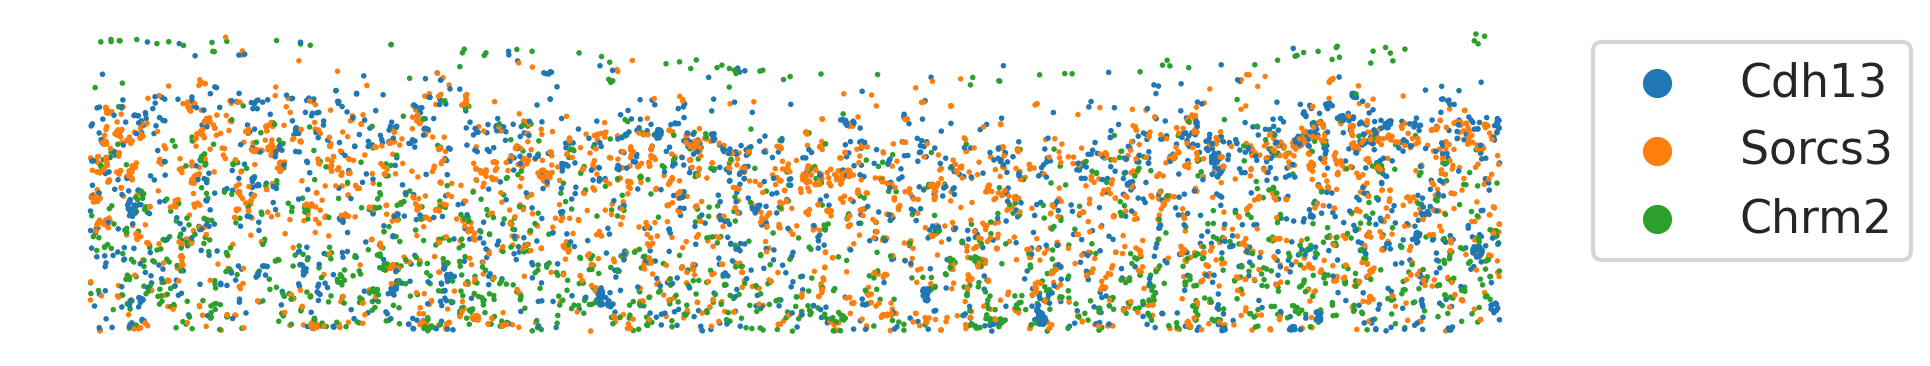

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
24,0,2758.5889,11228.652,0.0,2559.334436209702,1296.3086509501863,1236,Cdh4,ENSMUST00000000314,4267114801552100007,44.442418751740675,7157.76371322264
28,0,2724.732,11231.548,0.0,2585.322661027973,1318.2013132918255,1236,Cdh4,ENSMUST00000000314,-1,10.801865115784556,7162.558465007289
67,0,2786.383,11294.191,0.0,2586.02411095491,1230.3121830310247,1236,Cdh4,ENSMUST00000000314,4267114801552100018,75.87696707407329,7221.6365688624255
107,0,2808.6604,11362.264,0.0,2618.406490263416,1166.4248025081088,1236,Cdh4,ENSMUST00000000314,-1,101.69176203429119,7290.762679208906
130,0,2805.84,11395.08,0.0,2643.6052303604924,1145.2147103423486,1236,Cdh4,ENSMUST00000000314,-1,100.91262107819836,7326.070491020957
136,0,2804.0781,11407.068,0.0,2653.3278778911285,1137.983765687257,1236,Cdh4,ENSMUST00000000314,-1,99.2524084110014,7338.072996155705
9,1,2725.4832,11223.429,0.0,2579.0504824574914,1323.4111346342524

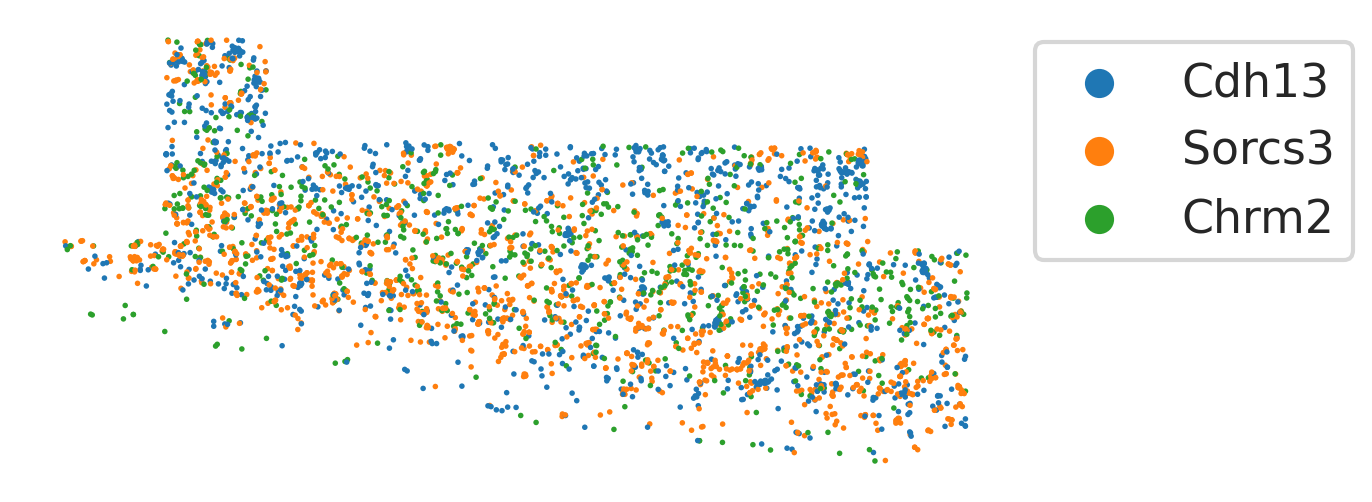

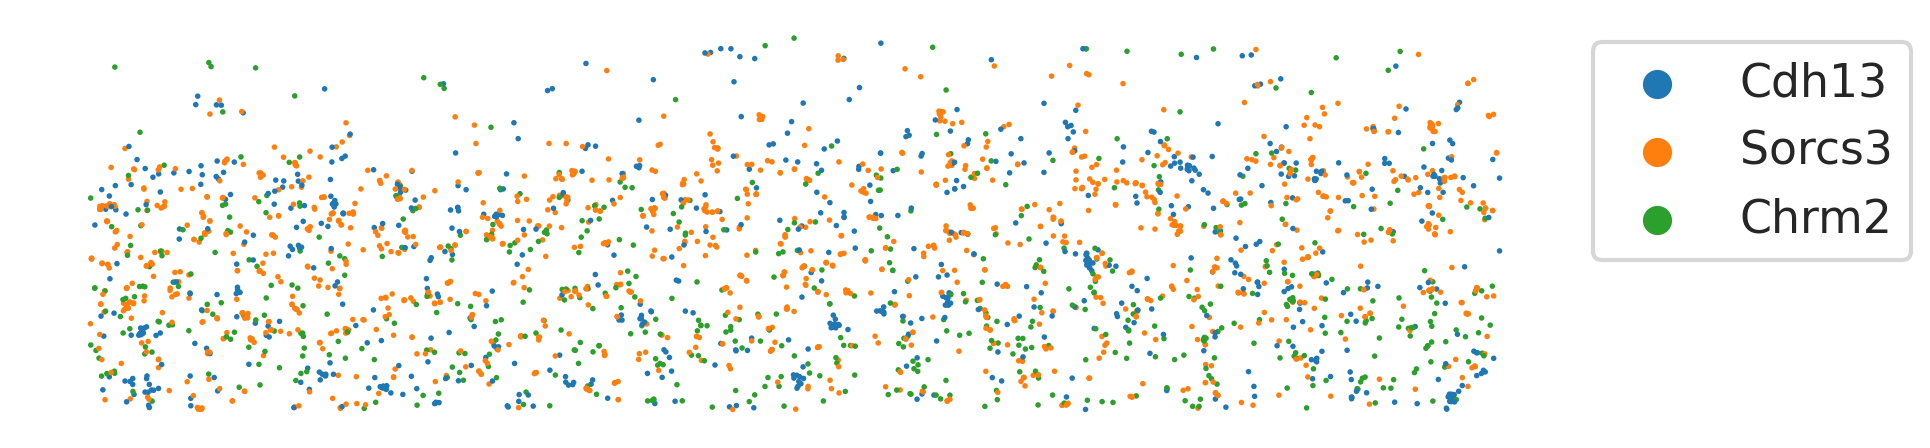

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
24,1,11871.314,12826.038,0.0,-1222.271176466175,2447.3919475515304,10,Pdgfra,ENSMUST00000000476,2027911802880100013,-6.296032081979764,2732.511392076416
29,1,11973.178,12833.748,0.0,-1137.909364735077,2505.001003414711,10,Pdgfra,ENSMUST00000000476,2027911802880100030,-3.3722358616023165,2834.604743856413
30,1,11968.837,12834.7295,0.0,-1142.1595310129064,2503.6805073485248,10,Pdgfra,ENSMUST00000000476,2027911802880100030,-4.782183882435842,2830.3834087798573
12,2,12004.146,12804.081,0.0,-1096.25679003068,2494.7926277606366,10,Kcnn3,ENSMUST00000000811,-1,29.387877614211313,2862.6092710085804
22,2,11917.186,12825.833,0.0,-1182.4423591437767,2470.150412343757,10,Kcnn3,ENSMUST00000000811,2027911802880100015,-1.0863101908612869,2778.102302910663
24,2,11910.534,12828.069,0.0,-1189.3211601297503,2468.7608451466167,10,Kcnn3,ENSMUST00000000811,2027911802880100029,-4.198652752466048,2771.7278983071865


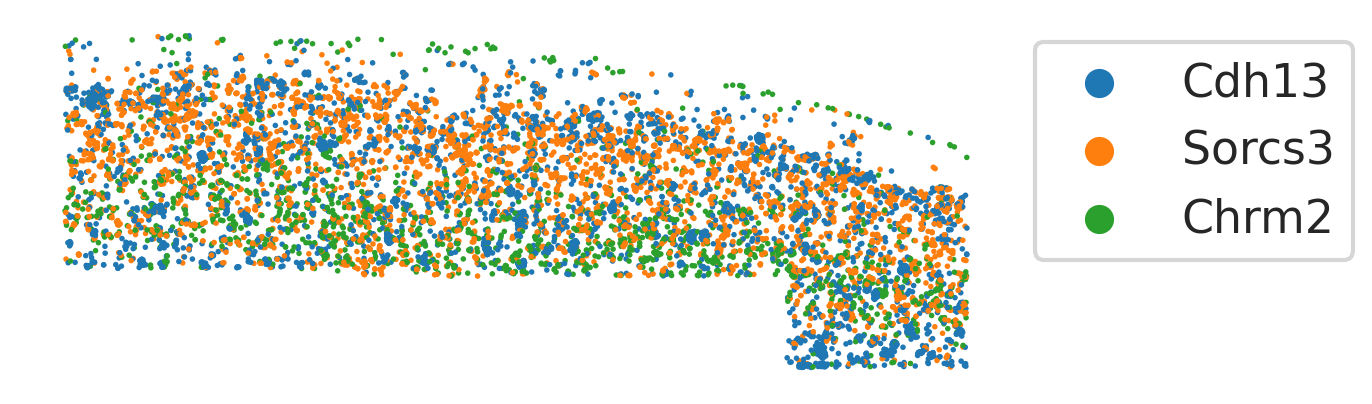

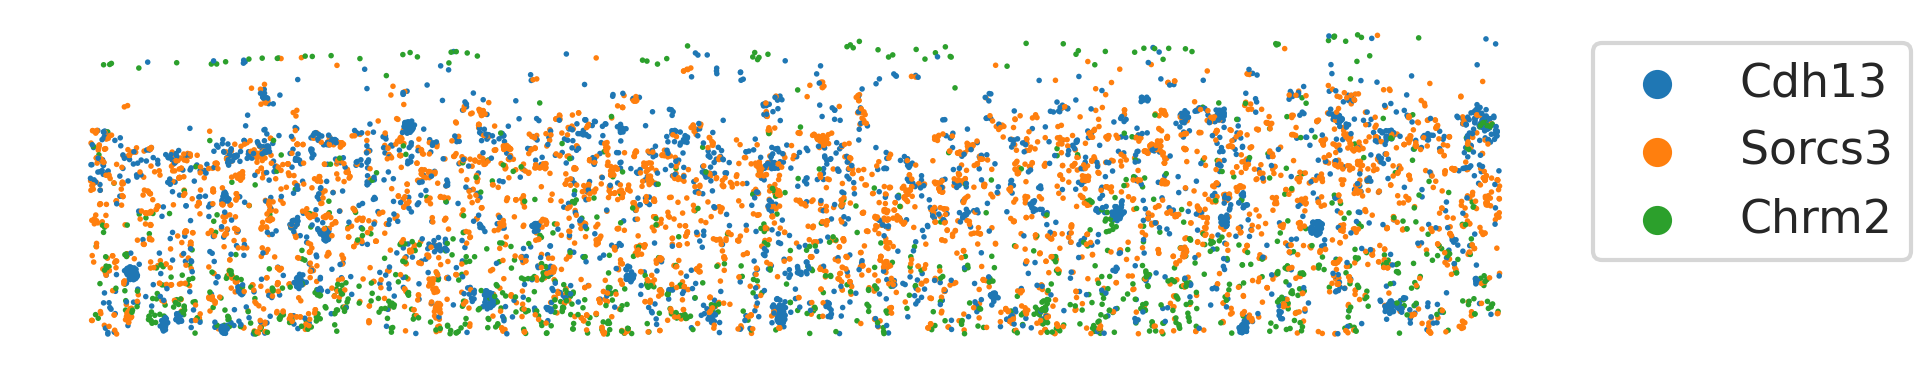

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
115,3,5045.7446,310.16425,0.0,-2755.385900054788,1016.4760906920637,852,S100a6,ENSMUST00000001051,2027846600149100041,92.81791664147195,1155.8345559476043
40,4,5111.8247,247.03813,0.0,-2846.5828812441205,1022.3580346068779,852,Col6a1,ENSMUST00000001147,-1,14.809643712836747,1108.229976367946
46,4,5150.948,257.46024,0.0,-2869.853864630807,989.2262626657534,852,Col6a1,ENSMUST00000001147,-1,14.810095130815487,1067.742287133583
47,4,5149.003,258.34784,0.0,-2867.7933699065825,989.7965435188821,852,Col6a1,ENSMUST00000001147,-1,16.168436413893346,1069.393277054415
54,4,5182.835,266.31625,0.0,-2888.5881902892816,961.9455969069732,852,Col6a1,ENSMUST00000001147,2027846600150100013,13.82070988314393,1034.347832879678
56,4,5194.499,268.58423,0.0,-2896.065503230804,952.7107487514845,852,Col6a1,ENSMUST00000001147,2027846600150100013,12.762758717424326,1022.512573329869
60,4,5207.027,276.4652,0.0,-2900.596

In [5]:
for name in names:
    print('**************************')
    print(name)
    run_one_sample(name)
    print('**************************')